# Machine Learning 

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings

# filter out warnings from sklearn library
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')


# Load data
X_train= pd.read_csv("../train/pheno_training_treated.csv")

X_test = pd.read_csv("../test/pheno_test_treated.csv")



/tmp/ipykernel_6140/3236968179.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = X_train.corr()


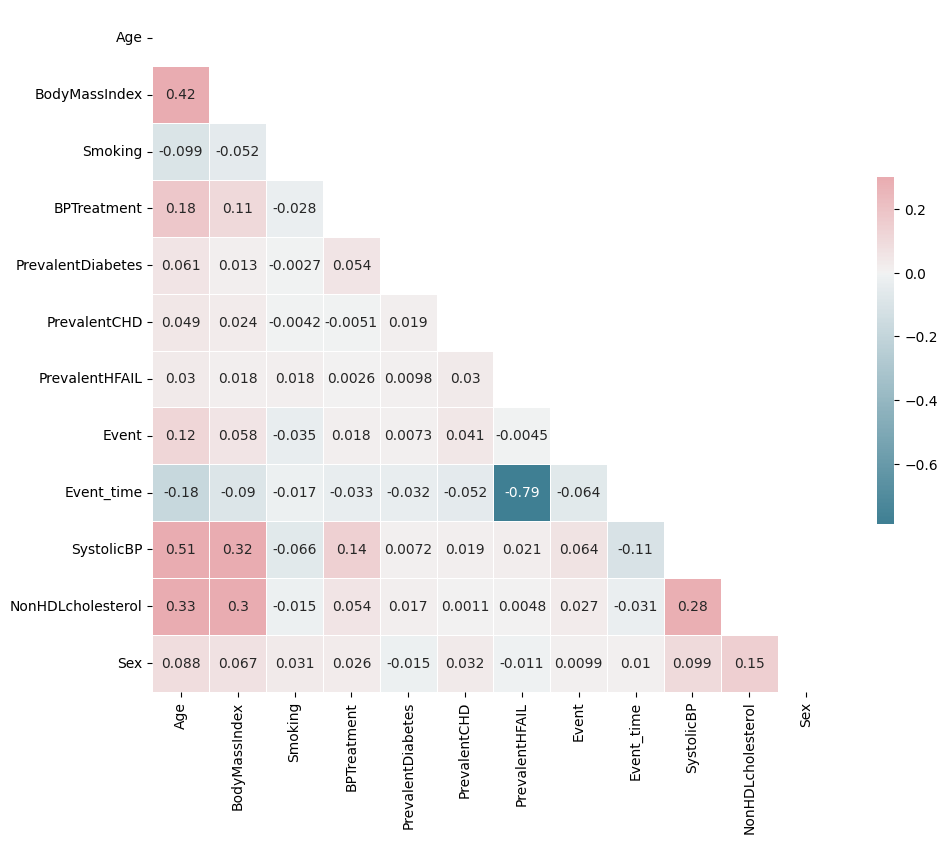

In [75]:
# Compute the correlation matrix
X_train = pd.DataFrame(X_train)
corr = X_train.corr()

# Create a mask to hide the upper triangle of the correlation matrix (redundant information)
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()


In [76]:
# preprocessing data for machine learning engineer

X_train.drop(columns=["Sample_ID"], inplace=True)
y_train = X_train.PrevalentHFAIL + X_train.Event # data target with the patients that had HF before and after the first data collecting
y_train = y_train.map({2: 1, 0: 0, 1: 1})
X_train.drop(columns=[ "PrevalentHFAIL","Event"], inplace=True)

X_test.drop(columns=["Sample_ID"], inplace=True)
y_test = X_test.PrevalentHFAIL  # data target with the patients that had HF before and after the first data collecting
y_test = y_test.map({2: 1, 0: 0, 1: 1})
X_test.drop(columns=[ "PrevalentHFAIL","Event"], inplace=True)


# SMOTE is used in unbalanced datasets to balance it
print(f'Original dataset shape {Counter(y_train)}')

# Since our dataset has an unbalanced number of 0 cases and 1 cases SMOTE is used to balance out this metrics making the training part of our model more accurate
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

print(f'Resampled dataset shape {Counter(y_train)}')

Original dataset shape Counter({0: 3229, 1: 386})
Resampled dataset shape Counter({0: 3229, 1: 3229})


In [77]:
from sklearn.feature_selection import SelectKBest

selector = SelectKBest(k=7)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_select = selector.transform(X_test)

# Get the selected features
selected_features = X_train.columns[selector.get_support()]

# Print the selected features
print(selected_features)

Index(['Age', 'BodyMassIndex', 'BPTreatment', 'PrevalentCHD', 'Event_time',
       'SystolicBP', 'Sex'],
      dtype='object')


In [78]:
# data preparation with selected features from SelectKBest
X_train = X_train.loc[:, selected_features]

X_test = X_test.loc[:, selected_features]



In [79]:

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Machine learning models

### Logistic Regression

In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

# Define the parameter grid
param_grid = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear']}

# Initialize the model
clf = LogisticRegression(random_state=42)

# Define the accuracy score as the performance metric
acc_scorer = make_scorer(accuracy_score)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, scoring=acc_scorer, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best accuracy score
print("Best parameters: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)


Best parameters:  {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best accuracy score:  0.6997567105443018


PECC (accuracy): 0.5865118850193477


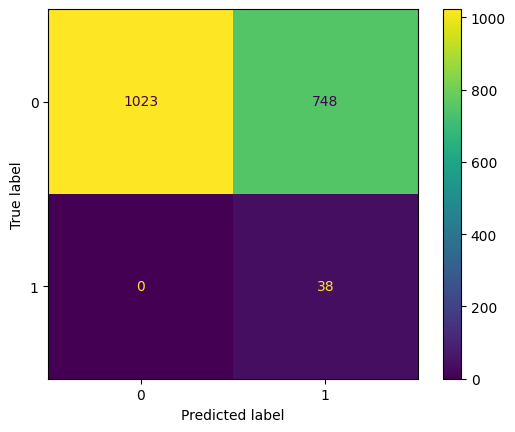

              precision    recall  f1-score   support

           0       1.00      0.58      0.73      1771
           1       0.05      1.00      0.09        38

    accuracy                           0.59      1809
   macro avg       0.52      0.79      0.41      1809
weighted avg       0.98      0.59      0.72      1809



In [94]:
best_params = grid_search.best_params_

# Initialize the model
clf = LogisticRegression(C=best_params["C"], penalty=best_params["penalty"], solver='liblinear')

# Fit the model to the training data
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the PECC accuracy
print("PECC (accuracy):", accuracy_score(y_test, y_pred))

# Plot the confusion matrix
cm_logreg = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=clf.classes_)
disp1.plot()
plt.show()

# print the classification report
print(classification_report(y_test, y_pred))

Cross-validation is a technique used to evaluate the performance of a machine learning model by training the model on different subsets of the data and evaluating its performance on the remaining subsets. The goal of cross-validation is to estimate the performance of a model on unseen data, the cross_val_score function has been used to perform a 5-fold cross-validation on the logistic regression model using the X_train and y_train data. The function returns an array of scores, one for each fold. The average of these scores is the estimated performance of the model on new unseen data. The output of this function is "Accuracy: 0.70 (+/- 0.04)", which means that the average accuracy of the model on the unseen data is 0.70 and the standard deviation of the accuracy is 0.04. This result shows that the model has an average accuracy of 70% and the model's performance varies 4% between the folds

In [ ]:
scores = cross_val_score(clf, X_train, y_train, cv=5)

print(f"Accuracy: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")

Accuracy: 0.70 (+/- 0.04)


### Support Vector Machine

Accuracy:  0.5726920950801547


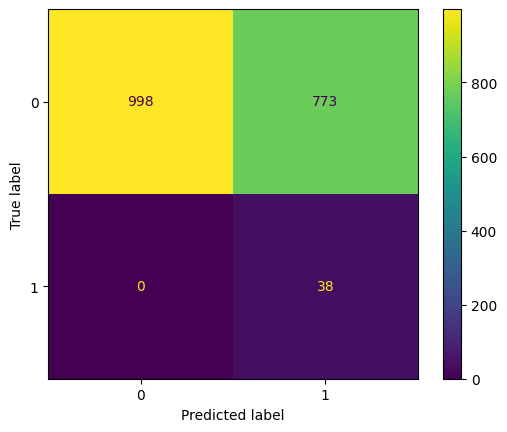

              precision    recall  f1-score   support

           0       1.00      0.56      0.72      1771
           1       0.05      1.00      0.09        38

    accuracy                           0.57      1809
   macro avg       0.52      0.78      0.41      1809
weighted avg       0.98      0.57      0.71      1809



In [ ]:
from sklearn.svm import SVC

# Initialize the model
clf = SVC(kernel="linear", random_state=42)

# Fit the model to the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the model's performance
accuracy = clf.score(X_test, y_test)
print("Accuracy: ", accuracy)

# Plot the confusion matrix
cm_logreg = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=clf.classes_)
disp1.plot()
plt.show()

# print the classification report
print(classification_report(y_test, y_pred))


In [43]:
scores = cross_val_score(clf, X_train, y_train, cv=5)

print(f"Accuracy: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")

Accuracy: 0.70 (+/- 0.05)


### Ridge regression

PECC (accuracy): 0.6014372581536761


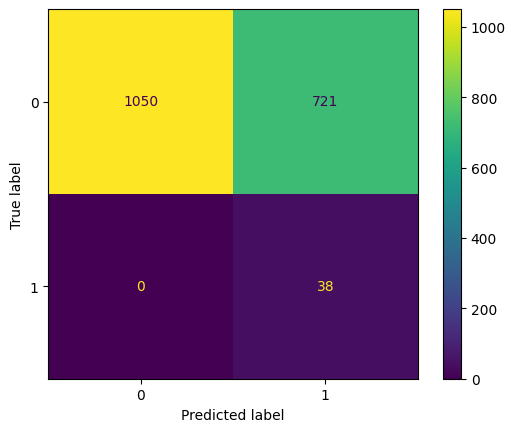

In [ ]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.1, max_iter=2000)
ridge.fit(X_train, y_train)

ridge_pred = ridge.predict(X_test)
ridge_pred = np.where(ridge_pred > 0.5, 1, 0)

print("PECC (accuracy):", accuracy_score(y_test, ridge_pred))
cm_ridge = confusion_matrix(y_test, ridge_pred)
disp_ridge = ConfusionMatrixDisplay(confusion_matrix=cm_ridge)
disp_ridge.plot()
plt.show()

### KNeighborsClassifier

Accuracy:  0.6810392482034273


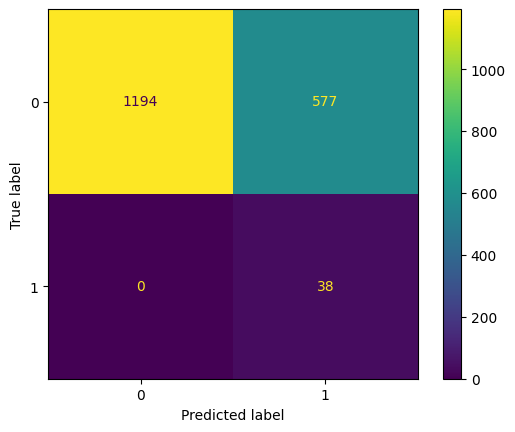

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the model
clf = KNeighborsClassifier(n_neighbors=5)

# Fit the model to the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the model's performance
accuracy = clf.score(X_test, y_test)
print("Accuracy: ", accuracy)

# plotting the confusion matrix 
cm_kn = confusion_matrix(y_test, y_pred)
disp_kn = ConfusionMatrixDisplay(confusion_matrix=cm_kn)
disp_kn.plot()
plt.show()


### Decision tree

Accuracy score: 0.2741846323935876


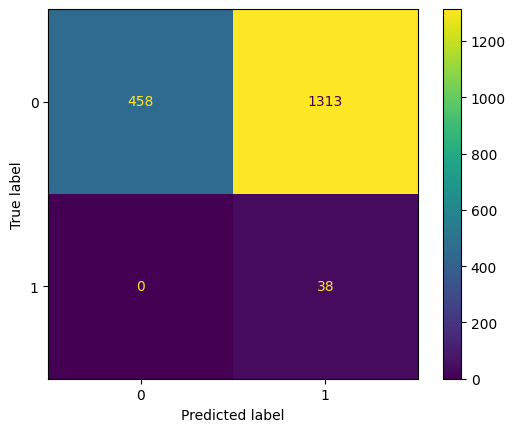

In [103]:
from sklearn.tree import DecisionTreeClassifier

# Initialize
clf = DecisionTreeClassifier()

# Fit the model to the entire training dataset
clf.fit(X_train, y_train)

# Get the predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy score
score = accuracy_score(y_test, y_pred)

# Print the score
print(f'Accuracy score: {score}')


# Plotting the confusion matrix
cm_tree = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=clf.classes_)
disp_tree.plot()
plt.show()
